In [2]:
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from pycaret.regression import *

In [3]:
crypto_currency = 'BNB'
against_currency ='USD'

In [4]:
start = dt.datetime(2021,1,1)
end = dt.datetime.now()-dt.timedelta(days=50)

In [5]:
yf.pdr_override()
data = pdr.get_data_yahoo("BNB-USD", start, end)

[*********************100%***********************]  1 of 1 completed


In [6]:
# df = setup(data,target = "Close", feature_interaction = True, feature_ratio = True,normalize=True,ignore_features=["Volume","Adj Close"],transform_target=True, use_gpu=True)

In [7]:
x

NameError: name 'x' is not defined

In [ ]:
# import sktime 
# from sktime.utils.plotting import plot_series
# from sktime.transformations.panel.rocket import Rocket
# y = data["Close"]
# x = data[data.columns]
# x.drop(["Close","Volume"],axis=1,inplace=True)
# plot_series(data["Close"])
# rocket = Rocket()
# rocket.fit(np.array(x))
# x_t = rocket.transform(np.array(x))

In [9]:
def difference(data, interval=1):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]
def invert_difference(orig_data, diff_data, interval=1):
	return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]
from scipy.stats import boxcox

In [10]:
final_data = pd.DataFrame()
final_data["Close_Open"] = data['Close']-data['Open']
final_data["High_Low"] = data['High']-data['Low']
final_data['Close'] = data['Close']
final_data.head()

,Close_Open,High_Low,Close
Date,,,
2020-12-31,-0.746254,1.419170,37.376034
2021-01-01,0.530437,1.881870,37.905010
2021-01-02,0.324486,1.910652,38.241592
2021-01-03,2.895252,3.788219,41.148979
2021-01-04,-0.271927,4.988140,40.926353


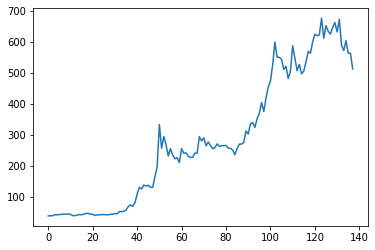

In [11]:
from scipy.special import boxcox1p
# fd =(boxcox1p(final_data["Close"]))#*np.log(boxcox1p(final_data["Close"],-1))
# plt.plot(fd)
plt.plot(np.array(final_data["Close"]))

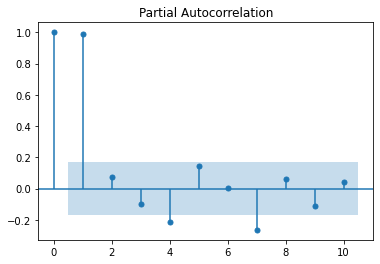

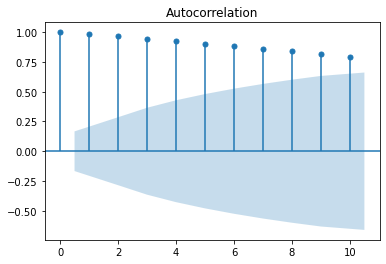

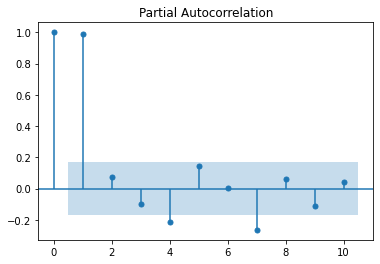

In [12]:
# Checking if our series is affected by past values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'], lags=10)
plot_pacf(data['Close'], lags=10)

In [13]:
np.array(final_data["Close"])
fd

NameError: name 'fd' is not defined

In [14]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_data.values)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)
prediction_days = 10
future_days=0
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_days):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days,2])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))

In [15]:
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(128, 10, 3)

In [16]:
# custom metric for our model, only to monitor our model while training
from tensorflow.keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [169]:
#creating neural netowrk
model = Sequential()                # could make units 50, for better prediction
model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu" ))
# model.add(Dropout(0.2))
model.add(LSTM(units=500, activation="relu"))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=100, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(units=1,activation="relu"))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
model.fit(x_train,y_train, epochs=80, batch_size=10)

Epoch 1/80
13/13 [==============================] - 3s 56ms/step - loss: 0.0912 - rmse: 0.2361
Epoch 2/80
13/13 [==============================] - 1s 57ms/step - loss: 0.0223 - rmse: 0.1112
Epoch 3/80
13/13 [==============================] - 1s 55ms/step - loss: 0.0075 - rmse: 0.0647
Epoch 4/80
13/13 [==============================] - 1s 55ms/step - loss: 0.0055 - rmse: 0.0565
Epoch 5/80
13/13 [==============================] - 1s 55ms/step - loss: 0.0048 - rmse: 0.0539
Epoch 6/80
13/13 [==============================] - 1s 54ms/step - loss: 0.0049 - rmse: 0.0525
Epoch 7/80
13/13 [==============================] - 1s 53ms/step - loss: 0.0047 - rmse: 0.0514
Epoch 8/80
13/13 [==============================] - 1s 53ms/step - loss: 0.0040 - rmse: 0.0476
Epoch 9/80
13/13 [==============================] - 1s 53ms/step - loss: 0.0038 - rmse: 0.0457
Epoch 10/80
13/13 [==============================] - 1s 54ms/step - loss: 0.0049 - rmse: 0.0524
Epoch 11/80
13/13 [==============================

[*********************100%***********************]  1 of 1 completed


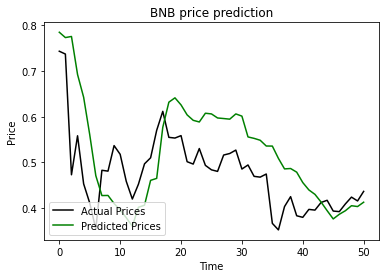

In [170]:
test_start = dt.datetime.now()-dt.timedelta(days=50)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo("BNB-USD", test_start, test_end)

final_test = pd.DataFrame()
final_test['Close_Open'] = test_data['Close'] - test_data['Open']
final_test['High_Low'] = test_data['High'] - test_data['Low']
final_test['Close'] = test_data['Close']

total_dataset = pd.concat((final_data,final_test),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:]
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs
model_inputs = scaler.transform(model_inputs)
actual_prices = (model_inputs[prediction_days:,2])#difference(np.log10((test_data['Close']))).to_numpy()



x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

prediction_prices = model.predict(x_test)
# prediction_prices = scaler.inverse_transform(prediction_prices)
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(actual_prices,color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left')
plt.show()

4/4 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0214


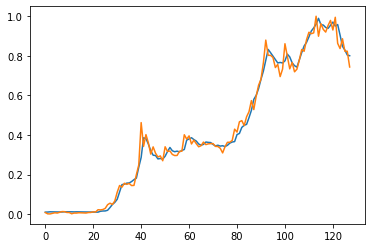

In [171]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
# (prediction_prices)
# plottiong training dataset  
model.evaluate(x_test,actual_prices)
model.evaluate(x_train,y_train)
plt.plot(model.predict(x_train))
plt.plot(y_train)

In [122]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

SyntaxError: unmatched ')' (<ipython-input-122-9cbb75c363d4>, line 1)

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

In [ ]:
# plt.plot(data['Open'])
# plt.plot(data['Close'])
plt.plot(data['High'] - data['Low'])
plt.plot(data['Close'] - data['Open'])
# plt.plot(data['Close'] - data['High'])
# plt.plot(data['Close'] - data['Low'])
# plt.plot(data['Low'])

## Bottom Line Notes
for 1000 epochs, model is overfitting, 500 seems fine to me. Might decrease the epochs from 500
Optimizer and loss are alright to i guess.
activation function is next (marked in to-do in github projects)

In [ ]:
# #creating neural netowrk  Good Model
# model = Sequential()                # could make units 50, for better prediction
# model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu" ))
# # model.add(Dropout(0.2))
# model.add(LSTM(units=500, activation="relu"))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=50,activation="relu"))
# # model.add(Dense(units=100, activation="relu"))
# # model.add(Dropout(0.2))

# model.add(Dense(units=1,activation="relu"))
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
# model.fit(x_train,y_train, epochs=100, batch_size=10)